This notebook is about Data Visualisation of high dimensional data to a lower dimension using Tensorboard with t-SNE and PCA dimensionality reduction techniques and exploration of data points with multiple parameter tuning.

## What is an Embedding?
* Embedding is a way to map discrete objects (images, words, etc.) to high dimensional vectors.
* The individual dimensions in these vectors typically have no inherent meaning. Instead, it's the overall patterns of location and distance between vectors that machine learning takes advantage of.
* Embeddings are important for input to machine learning. Classifiers, and neural networks more generally, work on vectors of real numbers. They train best on dense vectors, where all values contribute to define an object.
* Embeddings map objects to vectors, applications can use similarity in vector space (for instance, Euclidean distance or the angle between vectors) as a robust and flexible measure of object similarity. One common use is to find nearest neighbors.

## Workflow
To do a basic embedding visualisation, I'll follow the below workflow steps:
1. Read the Fashion MNIST data and create an X (image) and Y (label) batch
2. Create a Summary Writer
3. Configure the projector
4. Create the embedding Tensor from X
5. Run the TF session and create a model check-point
6. Create the sprite image
7. Create the metadata (labels) file

But first, let's import the necessary libraries:

In [1]:
# Import Numpy for statistical calculations
import numpy as np

# Import Pandas for data manipulation using dataframes
import pandas as pd

# Import Warnings 
import warnings
warnings.filterwarnings('ignore')
from IPython.display import Image
from IPython.core.display import HTML 

# Import matplotlib Library for data visualisation
import matplotlib.pyplot as plt
%matplotlib inline
import os
import tensorflow as tf
from tensorflow.contrib.tensorboard.plugins import projector
from tensorflow.examples.tutorials.mnist import input_data

# Input data files are available in the "data/" directory.
# For example, running this will list the files in the input directory
import os
print(os.listdir("data"))

['.DS_Store', 'fashion-mnist_test.csv', 'fashion-mnist_train.csv', 't10k-images-idx3-ubyte', 't10k-labels-idx1-ubyte', 'train-images-idx3-ubyte', 'train-labels-idx1-ubyte']


**1 - Read the Fashion MNIST test data and create an X (image) and Y (label) batch**

I will load the `fashion-mnist` test data into a pandas dataframe and subsequently convert it into a numpy array with datatype as float32.

In [2]:
test_data = np.array(pd.read_csv('data/fashion-mnist_test.csv'), dtype='float32')

Let's consider around 5000 images as part of the embedding.

In [3]:
embed_count = 5000

Now I will split the data into **X_test** for storing images and **Y_test** for storing labels. Since all images are ranging from 0-255, I will need to rescale all of them by dividing with 255 so that it reflects between 0 and 1.

In [4]:
X_test = test_data[:embed_count, 1:] / 255
Y_test = test_data[:embed_count, 0]

**2 - Create a Summary Writer**

To store all the events in a log directory for tensorboard view, I need to mention the path as below.

In [5]:
logdir = 'fashionMNIST-logs'

# Use this logdir to create a summary writer
summary_writer = tf.summary.FileWriter(logdir)

In [6]:
# Creating the embedding variable with all the images defined above under X_test
embedding_var = tf.Variable(X_test, name='fmnist_embedding')

**3 - Configure the projector**

This is the important part of embedding visualisation. Here I specify what variable I want for the project, what the metadata path is (the names and classes), and where to save the sprites.

In [7]:
# Format: tensorflow/contrib/tensorboard/plugins/projector/projector_config.proto
config = projector.ProjectorConfig()

# You can add multiple embeddings. Here I add only one.
embedding = config.embeddings.add()
embedding.tensor_name = embedding_var.name

# Link this tensor to its metadata file (e.g. labels).
embedding.metadata_path = os.path.join(logdir, 'metadata.tsv')

# After constructing the sprite, I need to tell the Embedding Projector where to find it
embedding.sprite.image_path = os.path.join(logdir, 'sprite.png')
embedding.sprite.single_image_dim.extend([28, 28])

**4 - Create the embedding Tensor from X**

In [8]:
# The next line writes a projector_config.pbtxt in the logdir. TensorBoard will read this file during startup.
projector.visualize_embeddings(summary_writer,config)

**5 - Run the TF session and create a model check-point**

In [9]:
# Periodically save the model variables in a checkpoint in logdir.
with tf.Session() as sesh:
    sesh.run(tf.global_variables_initializer())
    saver = tf.train.Saver()
    saver.save(sesh, os.path.join(logdir, 'model.ckpt'))

**6 - Create the sprite image**

This is used for making sprite images for the [embedding projector](http://projector.tensorflow.org/).

In [10]:
rows = 28 
cols = 28
label = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

sprite_dim = int(np.sqrt(X_test.shape[0]))
sprite_image = np.ones((cols * sprite_dim, rows * sprite_dim))

index = 0 
labels = [] 
for i in range(sprite_dim): 
    for j in range(sprite_dim):
        labels.append(label[int(Y_test[index])])

        sprite_image[
            i * cols: (i + 1) * cols,
            j * rows: (j + 1) * rows
        ] = X_test[index].reshape(28, 28) * -1 + 1

        index += 1

**7 - Create the metadata (labels) file**

Usually embeddings have metadata associated with it (e.g. labels, images). The metadata should be stored in a separate file outside of the model checkpoint, since the metadata is not a trainable parameter of the model.

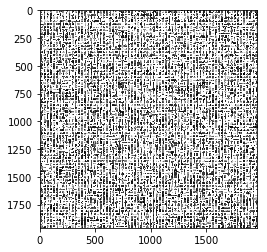

In [11]:
with open(embedding.metadata_path, 'w') as meta:
    meta.write('Index\tLabel\n')
    for index, label in enumerate(labels):
        meta.write('{}\t{}\n'.format(index, label))
        
plt.imsave(embedding.sprite.image_path, sprite_image, cmap='gray')
plt.imshow(sprite_image, cmap='gray')
plt.show()

The above figure represents the grayscale fashion products representation in lower dimension.Let us look more closer by zooming the picture as below:

![](zoom-in-pic.png)

## Launching TensorBoard
To run TensorBoard, use the following command:

`tensorboard --logdir=path/to/log-directory`

where `logdir` points to the directory where the `FileWriter` serialized its data. If this `logdir` directory contains subdirectories which contain serialized data from separate runs, then TensorBoard will visualize the data from all of those runs. Once TensorBoard is running, navigate your web browser to `localhost:6006` to view the TensorBoard.

When looking at TensorBoard, you will see the navigation tabs in the top right corner. Each tab represents a set of serialized data that can be visualized.

## Visualizing Embeddings
Visualising embeddings is a powerful technique! It helps you understand what your algorithm learned, and if this is what you expected it to learn.

TensorBoard includes the Embedding Projector, a tool that lets you interactively visualize embeddings. This tool can read embeddings from your model and render them in two or three dimensions.

The Embedding Projector has three panels:

* Data panel on the top left, where you can choose the run, the embedding variable and data columns to color and label points by.
* Projections panel on the bottom left, where you can choose the type of projection.
* Inspector panel on the right side, where you can search for particular points and see a list of nearest neighbors.

Here I'm particularly interested in projections. The Embedding Projector has three methods of reducing the dimensionality of a data set: two linear and one nonlinear. Each method can be used to create either a two- or three-dimensional view.

**Principal Component Analysis** 
A straightforward technique for reducing dimensions is Principal Component Analysis (PCA). The Embedding Projector computes the top 10 principal components. The menu lets you project those components onto any combination of two or three. PCA is a linear projection, often effective at examining global geometry.

![PCA](PCA-Vis.gif)

**t-SNE** 
A popular non-linear dimensionality reduction technique is t-SNE. The Embedding Projector offers both two- and three-dimensional t-SNE views. Layout is performed client-side animating every step of the algorithm. Because t-SNE often preserves some local structure, it is useful for exploring local neighborhoods and finding clusters.

![T-SNE](Tsne-Vis.png)

**Custom** You can also construct specialized linear projections based on text searches for finding meaningful directions in space. To define a projection axis, enter two search strings or regular expressions. The program computes the centroids of the sets of points whose labels match these searches, and uses the difference vector between centroids as a projection axis.

![Custom](Custom-Vis.png)

## Further Exploration
You can explore visually by zooming, rotating, and panning using natural click-and-drag gestures. Hovering your mouse over a point will show any metadata for that point. You can also inspect nearest-neighbor subsets. Clicking on a point causes the right pane to list the nearest neighbors, along with distances to the current point. The nearest-neighbor points are also highlighted in the projection. It is sometimes useful to restrict the view to a subset of points and perform projections only on those points. To do so, you can select points in multiple ways:

* After clicking on a point, its nearest neighbors are also selected.
* After a search, the points matching the query are selected.
* Enabling selection, clicking on a point and dragging defines a selection sphere.